### Batch the characters

wavenet (like) - we want to progressively form longer joins

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [2]:
embedding_size = 3
context_length = 8

In [3]:
%run names.py

ns = Names(context_length)

ns.get_names("names.txt")

x_names, y_names = ns.get_xys()
samples_length = len(y_names)
train_length = math.floor(samples_length * .8)
dev_offset = math.floor(samples_length * .9)

dev = list(zip(x_names[train_length: dev_offset], y_names[train_length: dev_offset]))
test = list(zip(x_names[dev_offset:], y_names[dev_offset:]))

train = list(zip(x_names[:train_length], y_names[:train_length]))

def sample_names(sample_size = 5, p = train):
    samples = random.sample(p, sample_size)
    x_samples = [s[0] for s in samples]
    y_samples = [s[1] for s in samples]
    return x_samples, y_samples

###### lets look at layers

take 5 samples from our names sampler

we generate a random embedding for demonstation (we keep it simple with a 3d embedding) 

so when we *lookup* our samples' letters in the embedding we get a 5, 8, 3 tensor

5 samples of length 8, embedded in a 3d space

In [4]:
samples = torch.tensor(sample_names()[0])
print(samples)
pretend_emb = torch.randn(27, embedding_size)

emb = pretend_emb[samples]
print(emb.shape)
emb[0]

tensor([[ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 0,  0,  0,  0, 13,  3,  3, 15],
        [14, 14,  1, 12,  5,  9,  7,  8],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  1, 22,  1]])
torch.Size([5, 8, 3])


tensor([[ 1.2189, -0.1887, -0.0962],
        [ 1.2189, -0.1887, -0.0962],
        [ 1.2189, -0.1887, -0.0962],
        [ 1.2189, -0.1887, -0.0962],
        [ 1.2189, -0.1887, -0.0962],
        [ 1.2189, -0.1887, -0.0962],
        [ 1.2189, -0.1887, -0.0962],
        [-0.2148,  0.1242, -0.4712]])

now we want to break up that 8 length sample into 4 pairs

we can just reshape it

so each row when we print is a letter, and our letters are grouped into twos

In [5]:
emb.view(5, 4, 2, 3)[0]

tensor([[[ 1.2189, -0.1887, -0.0962],
         [ 1.2189, -0.1887, -0.0962]],

        [[ 1.2189, -0.1887, -0.0962],
         [ 1.2189, -0.1887, -0.0962]],

        [[ 1.2189, -0.1887, -0.0962],
         [ 1.2189, -0.1887, -0.0962]],

        [[ 1.2189, -0.1887, -0.0962],
         [-0.2148,  0.1242, -0.4712]]])

to feed this into our network we'll actually reshape fusing the last 2 dimesions so that we get 2 * emb_dimensions

this makes it harder to see what's happening so we did that intermediate step

now each row is a pair of letters from above

In [6]:
emb.view(5, 4, 6)[0]

tensor([[ 1.2189, -0.1887, -0.0962,  1.2189, -0.1887, -0.0962],
        [ 1.2189, -0.1887, -0.0962,  1.2189, -0.1887, -0.0962],
        [ 1.2189, -0.1887, -0.0962,  1.2189, -0.1887, -0.0962],
        [ 1.2189, -0.1887, -0.0962, -0.2148,  0.1242, -0.4712]])

## a naive attempt
NGramFlatten and FlattenConsecutive will both create the same output on calling emb but we'll see later 
why FlattenConsecutive won't work in our full model

In [7]:
class NGramFlatten:

    def __init__(self, n, dim):
        self.n = n
        self.dim = dim
        self.type = 'flatten'

    def __call__(self, x):
        x = x.view(x.shape[0], -1, self.n * self.dim)
        
        self.out = x
        return self.out

    def parameters(self):
        return []

In [8]:
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
        self.type = 'flatten'

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, self.n * C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

In [9]:
n_flatten = NGramFlatten(2, embedding_size)

out = n_flatten(emb)

fc = FlattenConsecutive(2)
outb = fc(emb)

out.shape, outb.shape

(torch.Size([5, 4, 6]), torch.Size([5, 4, 6]))

## repeat the layers from before

In [10]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out))
    self.bias = torch.zeros(fan_out) if bias else None
    self.type = 'linear'
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def kaiming(self, nonlin):
    nn.init.kaiming_normal_(self.weight, nonlinearity=nonlin)
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [11]:
class Tanh:
  def __init__(self):
    self.type = 'non-linearity'
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Relu:
  def __init__(self):
    self.type = 'non-linearity'
  def __call__(self, x):
    self.out = torch.relu(x)
    return self.out
  def parameters(self):
    return []

class Gelu:
  def __init__(self):
    self.type = 'non-linearity'
  def __call__(self, x):
    self.out = torch.gelu(x)
    return self.out
  def parameters(self):
    return []

In [12]:
class Embedding:

    def __init__(self, vocab_size, embedding_dims):
        self.weight = torch.randn(vocab_size, embedding_dims)
        self.type = 'embedding'

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __init__(self):
        self.type = 'flatten'

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [13]:
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [14]:
@torch.no_grad()
def split_loss(split):
    dx = [s[0] for s in split]
    dy = torch.tensor([s[1] for s in split])
    logits = model(dx)
    return F.cross_entropy(logits, dy).item()

In [15]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    self.type = 'batch_norm_1d'
  
  def __call__(self, x):
    # calculate the forward pass
    if x.ndim == 2: 
      dim = 0
    if x.ndim == 3:
      dim = (0, 1)
    if self.training:
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [16]:
embedding_size = 3 # the dimensionality of the character embedding vectors

vocab_size = 27
nonlin='relu'

In [17]:
ln1 = Relu()
ln2 = Relu()
ln3 = Relu()
n_hidden = 60

model = Sequential([
    Embedding(vocab_size, embedding_size),
    FlattenConsecutive(2),
    Linear(embedding_size * 2, n_hidden, bias=False), 
    ln1,
    nn.LayerNorm(n_hidden),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False), 
    ln2,
    nn.LayerNorm(n_hidden),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False), 
    ln3,
    nn.LayerNorm(n_hidden),
    Linear(n_hidden, vocab_size, bias=True),
])

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
# should probably be a function on the model?
for p in parameters:
  p.requires_grad = True

print(vocab_size, embedding_size)

16848
27 3


In [18]:
with torch.no_grad():
    for layer in model.layers[:-1]:
        if layer.type == 'linear':
            layer.weight *= 5/3
    # last layer: make less confident
    if hasattr(model.layers[-1], 'gamma'):
        model.layers[-1].gain *= .1
    else:
        model.layers[-1].weight *= 0.5

In [35]:
names_length = train_length
epochs = 190
batch_size = 20
sample_loops = 8000

learning_rate = .1

running_loss = []
running_lr = []

ud_ratio = []

lr_step = {
    3: { 0: .1, 80: .01, 121: .001},
    9: { 0: .1, 100: .02, 161: .004}
}
train_length

182516

In [20]:
lrs = lr_step[embedding_size]
if lrs == None:
    lrs = lr_step[0]

for ep in range(epochs):
    epoch_loss = 0
    for s in range(sample_loops):
        x, y = sample_names(batch_size)
        Y = torch.tensor(y)
        X = torch.tensor(x)

        logits = model(X)

        loss = F.cross_entropy(logits, Y) # loss function
        
        with torch.no_grad():
            epoch_loss += loss

        # again stuff on parameters should probably be in model?
        for p in parameters:
          p.grad = None
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad

    #just keep any epoch stuff in a no grad block
    with torch.no_grad():
        if ep in lrs:
            learning_rate = lrs[ep]

        running_loss.append(epoch_loss.item())
        running_lr.append(learning_rate)

        ud_ratio.append([ (learning_rate*p.grad.std()/ p.data.std()).log10().item() for p in parameters ])
    
        if ep % 10 == 0:
            print(epoch_loss/sample_loops)
            learning_rate *= .92
            print(ep, learning_rate)

tensor(2.5607)
0 0.09200000000000001
tensor(2.3151)
10 0.08464000000000002
tensor(2.2796)
20 0.07786880000000002
tensor(2.2625)
30 0.07163929600000002
tensor(2.2505)
40 0.06590815232000002
tensor(2.2729)
50 0.06063550013440003
tensor(2.2427)
60 0.05578466012364803
tensor(2.2275)
70 0.05132188731375619
tensor(2.2260)
80 0.0092
tensor(2.2147)
90 0.008464000000000001
tensor(2.2122)
100 0.007786880000000001
tensor(2.2204)
110 0.007163929600000001
tensor(2.2091)
120 0.0065908152320000015
tensor(2.2070)
130 0.00092
tensor(2.2156)
140 0.0008464000000000001
tensor(2.2094)
150 0.0007786880000000001
tensor(2.2072)
160 0.0007163929600000001
tensor(2.2041)
170 0.0006590815232000001
tensor(2.2082)
180 0.0006063550013440002


In [21]:
tr = split_loss(train)
dv = split_loss(dev)
print("train", tr, "dev", dv)

train 2.160759449005127 dev 2.1793882846832275


In [22]:
import matplotlib.pyplot as plt

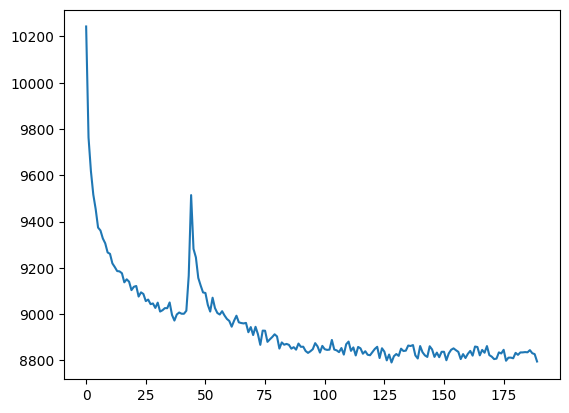

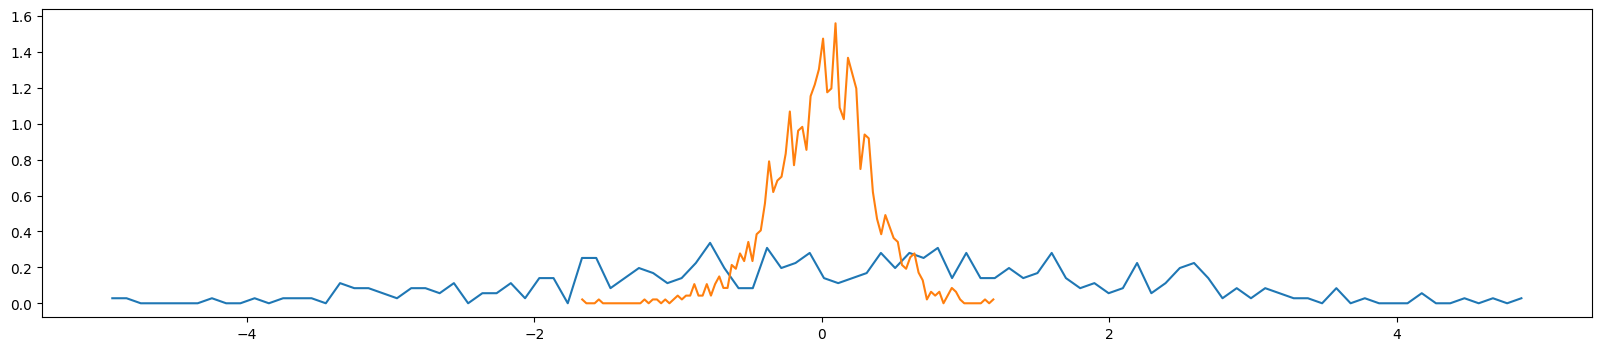

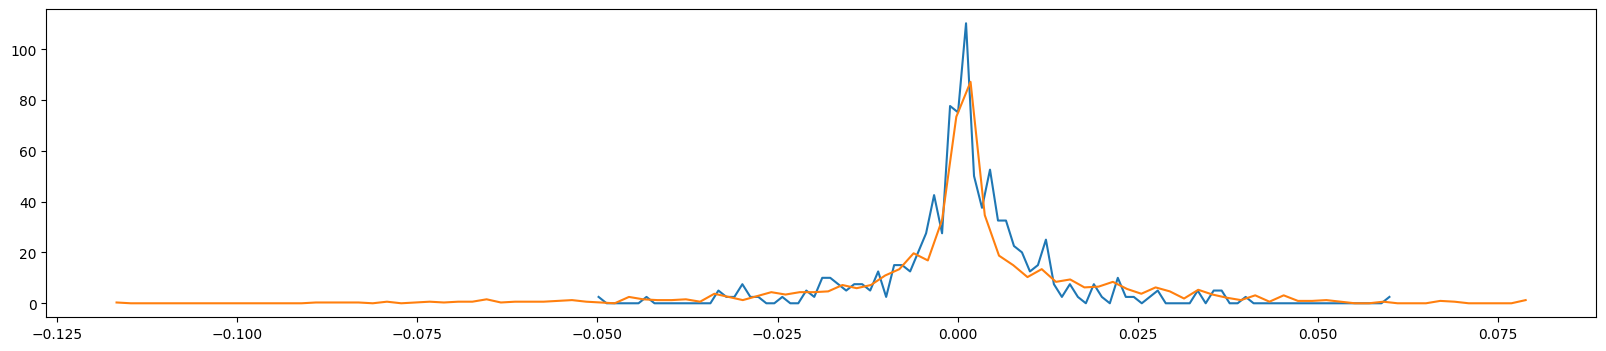

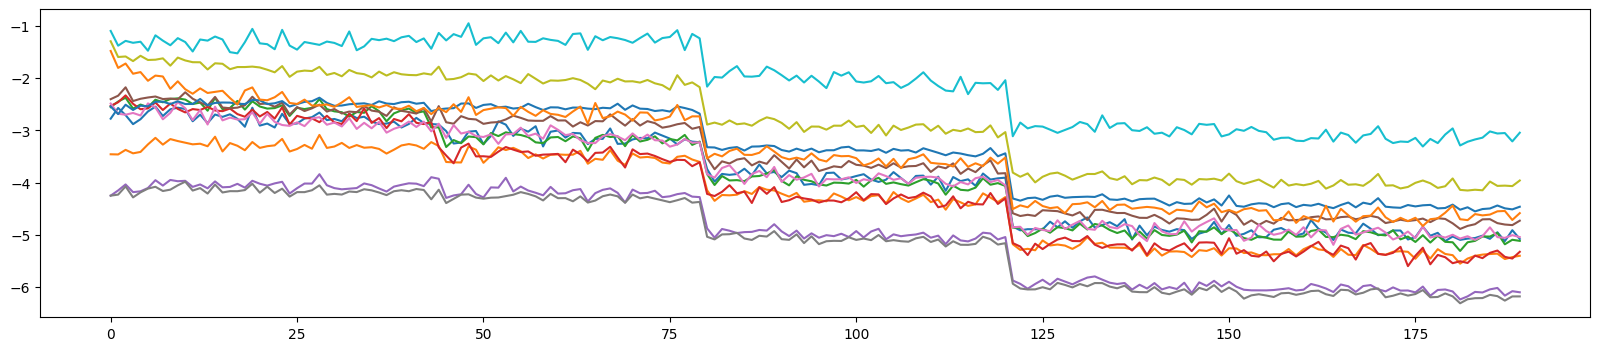

In [23]:
eps = [i for i in range(190)]
ls = [l for l in running_loss]

plt.plot(eps, ls)

t = model.layers[2].weight.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = model.layers[-1].weight.detach()
h2y, h2x = torch.histogram(t2, density=True)

plt.plot(h2x.detach()[1:], h2y.detach())

# look at our gradient distributions

t = model.layers[2].weight.grad.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = model.layers[-1].weight.grad.detach()
h2y, h2x = torch.histogram(t2, density=True)

plt.plot(h2x.detach()[1:], h2y.detach())

plt.figure(figsize=(20,4))
plt.plot(ud_ratio)

Ok lets try a simpler version without batchnorm (which kills my laptop)

In [45]:
context_length = 4
embedding_size = 3

ns = Names(context_length)

ns.get_names("names.txt")

x_names, y_names = ns.get_xys()
samples_length = len(y_names)
train_length = math.floor(samples_length * .8)
dev_offset = math.floor(samples_length * .9)

dev = list(zip(x_names[train_length: dev_offset], y_names[train_length: dev_offset]))
test = list(zip(x_names[dev_offset:], y_names[dev_offset:]))

train = list(zip(x_names[:train_length], y_names[:train_length]))

def sample_names(sample_size = 5, p = train):
    samples = random.sample(p, sample_size)
    x_samples = [s[0] for s in samples]
    y_samples = [s[1] for s in samples]
    return x_samples, y_samples

In [64]:
def model_init(e_s, h_s):
    ln1 = Relu()
    ln2 = Relu()
    
    model = Sequential([
        Embedding(vocab_size, e_s),
        FlattenConsecutive(2),
        Linear(embedding_size * 2, h_s, bias=False), 
        nn.LayerNorm(h_s),
        ln1,
        FlattenConsecutive(2),
        Linear(h_s * 2, h_s, bias=False), 
        nn.LayerNorm(h_s),
        ln2,
        Linear(h_s, vocab_size, bias=True),
    ])
    
    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters)) # number of parameters in total
    # should probably be a function on the model?
    for p in parameters:
      p.requires_grad = True
    
    print(vocab_size, embedding_size)

    return model

embedding_size

9

In [65]:
epochs = 160
batch_size = 200
sample_loops = 8000

hidden_size = 100

embed = 9

lr_step = {
    0: { 0: .1},
    3: { 0: .1},
    9: { 0: .1, 100: .02}
}

lrs = lr_step[embed]

m_setup = {
    "embed": embed,
    "epochs": epochs,
    "batch_size": batch_size,
    "sample_loops": sample_loops,
    "hidden_size": hidden_size,
    "learning_rates": lrs
}

md = model_init(embed, hidden_size)
parameters = md.parameters()

learning_rate = lrs[0]

running_loss = []
running_lr = []

ud_ratio = []

25170
27 9


In [66]:
for ep in range(epochs):
    epoch_loss = 0
    for s in range(sample_loops):
        x, y = sample_names(batch_size)
        Y = torch.tensor(y)
        X = torch.tensor(x)

        logits = md(X)

        loss = F.cross_entropy(logits, Y) # loss function
        
        with torch.no_grad():
            epoch_loss += loss

        # again stuff on parameters should probably be in model?
        for p in parameters:
          p.grad = None
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad

    #just keep any epoch stuff in a no grad block
    with torch.no_grad():
        if ep in lrs:
            learning_rate = lrs[ep]

        running_loss.append(epoch_loss.item())
        running_lr.append(learning_rate)

        ud_ratio.append([ (learning_rate*p.grad.std()/ p.data.std()).log10().item() for p in parameters ])
    
        if ep % 10 == 0:
            print(epoch_loss/sample_loops)
            learning_rate *= .92
            print(ep, learning_rate)

tensor(2.4411)
0 0.09200000000000001
tensor(2.1589)
10 0.08464000000000002
tensor(2.1203)
20 0.07786880000000002
tensor(2.0933)
30 0.07163929600000002
tensor(2.0777)
40 0.06590815232000002
tensor(2.0701)
50 0.06063550013440003
tensor(2.0586)
60 0.05578466012364803
tensor(2.0507)
70 0.05132188731375619
tensor(2.0440)
80 0.0472161363286557
tensor(2.0390)
90 0.043438845422363245
tensor(2.0360)
100 0.0184
tensor(2.0303)
110 0.016928000000000002
tensor(2.0288)
120 0.015573760000000002
tensor(2.0277)
130 0.014327859200000003
tensor(2.0254)
140 0.013181630464000003
tensor(2.0247)
150 0.012127100026880003


In [67]:
tr = split_loss(train)
dv = split_loss(dev)
print("train", tr, "dev", dv, m_setup)

train 2.026074171066284 dev 2.072094678878784 {'embed': 9, 'epochs': 160, 'batch_size': 200, 'sample_loops': 8000, 'hidden_size': 100, 'learning_rates': {0: 0.1, 100: 0.02}}


In [60]:
tr = split_loss(train)
dv = split_loss(dev)
print("train", tr, "dev", dv, m_setup)

train 2.026074171066284 dev 2.072094678878784 {'embed': 9, 'epochs': 160, 'batch_size': 200, 'sample_loops': 8000, 'hidden_size': 100, 'learning_rates': {0: 0.1}}


In [46]:
tr = split_loss(train)
dv = split_loss(dev)
print("train", tr, "dev", dv)

train 2.0748653411865234 dev 2.0721700191497803


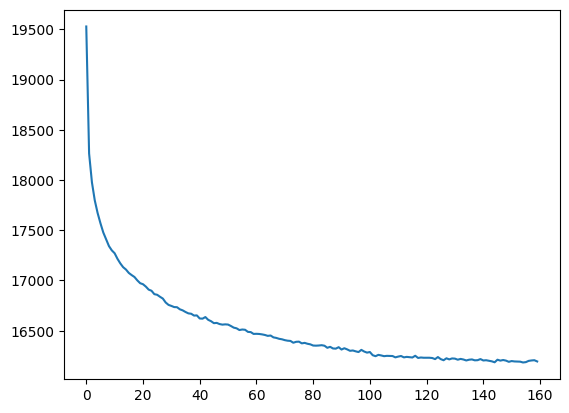

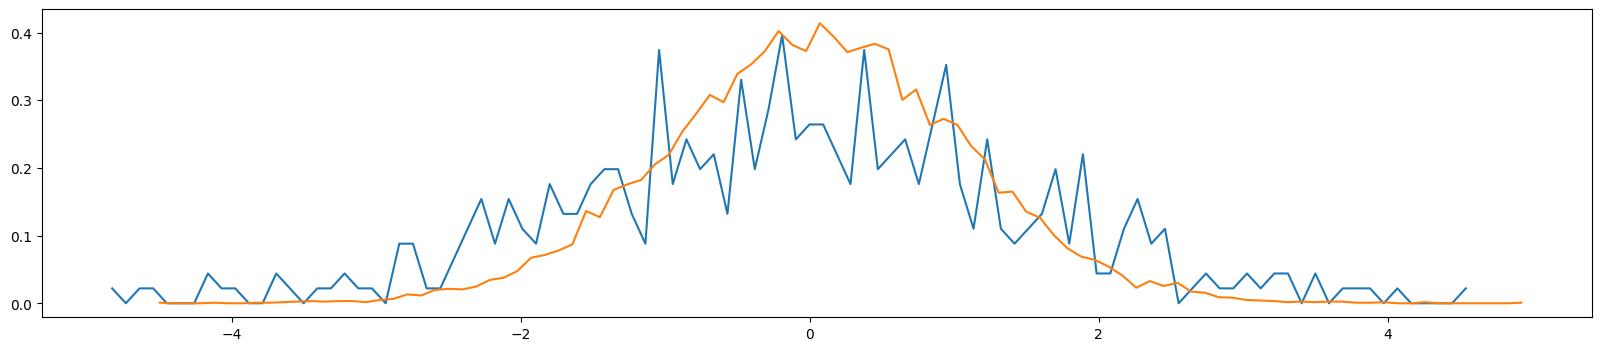

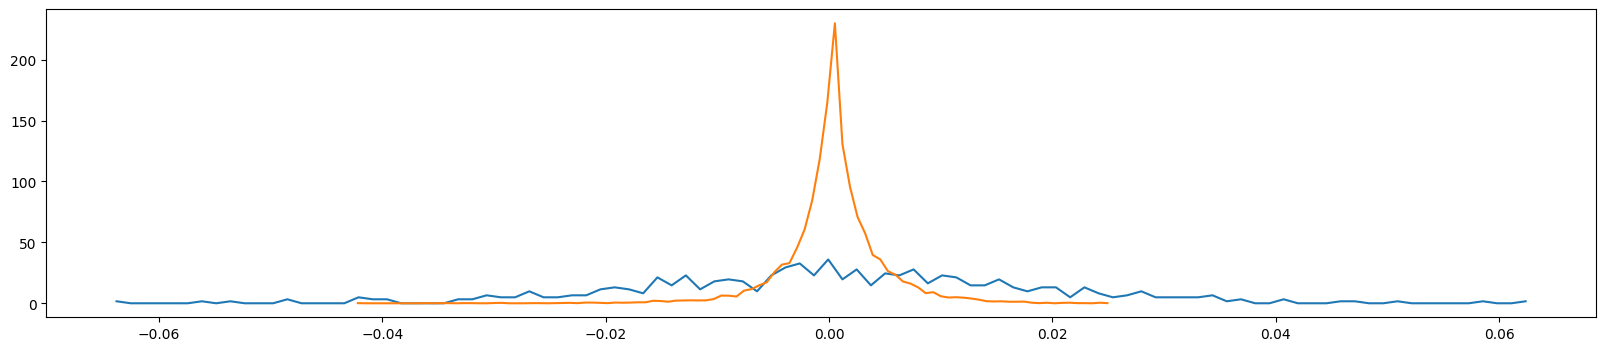

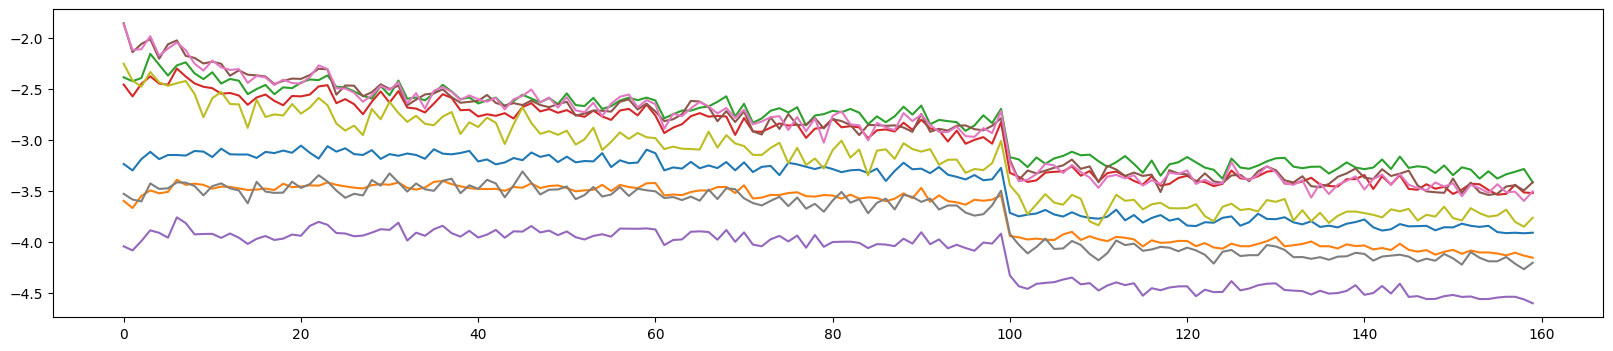

In [68]:
eps = [i for i in range(len(running_loss))]
ls = [l for l in running_loss]

plt.plot(eps, ls)

t = model.layers[2].weight.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = model.layers[-4].weight.detach()
h2y, h2x = torch.histogram(t2, density=True)
plt.plot(h2x.detach()[1:], h2y.detach())

# look at our gradient distributions

t = model.layers[2].weight.grad.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = model.layers[-4].weight.grad.detach()
h2y, h2x = torch.histogram(t2, density=True)
plt.plot(h2x.detach()[1:], h2y.detach())


plt.figure(figsize=(20,4))
plt.plot(ud_ratio)